In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.utils
import os
import matplotlib.pyplot as plt

from google.colab import drive

from google.colab import files
import shutil

In [ ]:
drive.mount("/content/drive") 

Mounted at /content/drive


In [ ]:
# kukkakuva-aineisto, käytetään tunneilla.
# myöhemmin kun sinulla on oma aineisto Google Drivessä,
# aseta data_dir -muuttujan arvoksi oman kuvakansiosi polku (path)
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

print(data_dir)

228827136/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


In [ ]:
# kuviin liittyvät parametrit
# yleensä vain IMAGE_SIZEä pitää muuttaa, jos neuroverkko tarvitsee
# tietyn kokoisia kuvia
# BATCH_SIZE on yleensä joko 32 tai 64, määrää sen minkäkokoisissa 
# osissa kuva syötetään neuroverkolle koulutusvaiheessa
IMAGE_SIZE = 224
BATCH_SIZE = 32
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# tämä preprocessing-funktio pitää aina muuttaa kohdalleen, jos vaihdat pohjamodelia!
# tämä esimerkki on viritetty mobilenet_v2:a varten
preprocess_function = keras.applications.mobilenet_v2.preprocess_input

# tehdään ImageDataGenerator neuroverkkoa varten
# kommentoidut parametrit liittyvät tiedon normalisointiin ja 
# data augmentointiin, käytä niitä harkiten!
# validation_split on tässä esimerkissä 20%, eli koulutukseen menee
# 80% kuvista, ja loput testiaineistoksi
datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = preprocess_function,
    # rescale=1./255, 
    # shear_range = 0.1,
    # rotation_range=0.1,
    # zoom_range = 0.1,
    # horizontal_flip=True,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    validation_split=0.2)

# koulutusaineisto, shufflen on hyvä olla True, jotta neuroverkko saa
# satunnaisemmin kuvia eri kategorioista, yleensä parantaa lopputulosta
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    subset='training')

# testaus/validointiaineisto
# TÄSSÄ ON TÄRKEÄÄ ETTÄ SHUFFLE ON FALSE
# muuten testiaineiston nimet ja kuvat menevät sekaisin, ja 
# malli oppii tunnistamaan kuvia miten sattuu
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    shuffle=False,
    subset='validation')

# tallennetaan kategorioiden nimet (eli kansionimet) talteen 
# myöhempää käyttöä varten (diagnostiikka ym.)
class_names = list(train_generator.class_indices.keys())
print(class_names)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# haetaan pohjalle MobileNetV2, tätä muutetaan sitä mukaa kun tarvitaan
# toista modelia tilalle
# huomio: jos käytät ResNet => aseta lisäparametri: pooling='avg'
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

# jäädytetään pohjamodel, ettei vahingossa kouluteta myös siihen uusia arvoja
# jos tämä unohtuu koodista, mallin koulutusvaihe jumittaa aika pitkälle paikallaan
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# tämä kytkee base_modelin meidän omaan neuroverkonpätkään
# käyttämällä Flatten-layeria välissä
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
# asetetaan neuroverkon koulutuksen parametrit ennen koulutusta
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# tulostetaan yhteenveto mitä koko neuroverkko sisältää
# kätevä tarkistaa tätä kautta puuttuuko verkon kytkennästä jotain!
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16056576  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 18,315,845
Trainable params: 16,057,861
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# asetetaan epochit ja pistetään neuroverkko kouluttamaan!
# jos oma neuroverkko, 25-50 on hyvä lähtökohta
# jos transfer learning, 10-20 on aluksi hyvä
epochs = 15

# tässä sitten vierähtää tovi, jos epocheja on paljon, neuroverkko on 
# monimutkainen ja/tai aineisto on suuri
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Epoch 1/15
92/92 [==============================] - 49s 193ms/step - loss: 3.5017 - accuracy: 0.7047 - val_loss: 0.5063 - val_accuracy: 0.8263
Epoch 2/15
92/92 [==============================] - 16s 175ms/step - loss: 0.4761 - accuracy: 0.8360 - val_loss: 0.5399 - val_accuracy: 0.8440
Epoch 3/15
92/92 [==============================] - 16s 175ms/step - loss: 0.4136 - accuracy: 0.8670 - val_loss: 0.4420 - val_accuracy: 0.8427
Epoch 4/15
92/92 [==============================] - 16s 177ms/step - loss: 0.3702 - accuracy: 0.8864 - val_loss: 0.4223 - val_accuracy: 0.8714
Epoch 5/15
92/92 [==============================] - 16s 175ms/step - loss: 0.3118 - accuracy: 0.9003 - val_loss: 0.4643 - val_accuracy: 0.8536
Epoch 6/15
92/92 [==============================] - 16s 176ms/step - loss: 0.2538 - accuracy: 0.9102 - val_loss: 0.4655 - val_accuracy: 0.8577
Epoch 7/15
92/92 [==============================] - 16s 175ms/step - loss: 0.2064 - accuracy: 0.9228 - val_loss: 0.4310 - val_accuracy: 0.8618

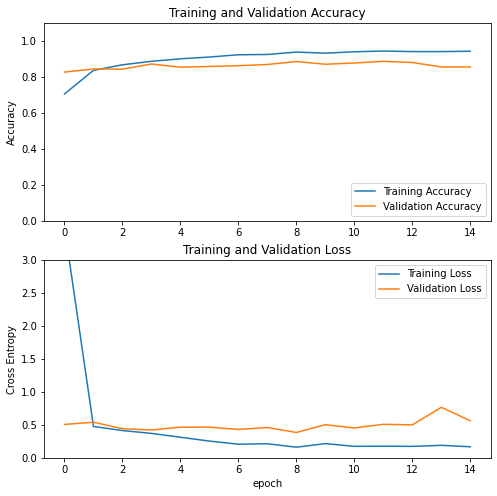

In [ ]:
# visualisoidaan training_accuracy, training_loss, val_accuracy ja val_loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


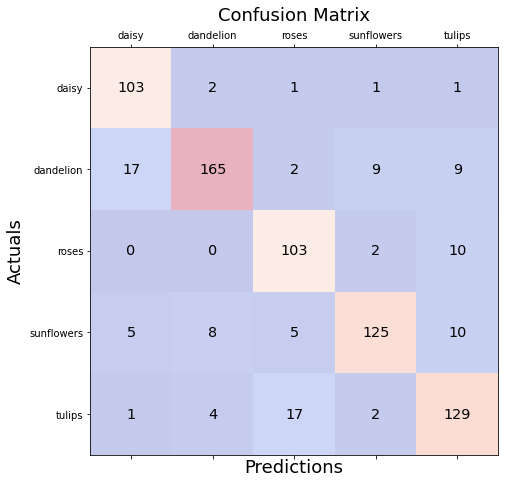


              precision    recall  f1-score   support

       daisy       0.95      0.82      0.88       126
   dandelion       0.82      0.92      0.87       179
       roses       0.90      0.80      0.85       128
  sunflowers       0.82      0.90      0.86       139
      tulips       0.84      0.81      0.83       159

    accuracy                           0.85       731
   macro avg       0.87      0.85      0.86       731
weighted avg       0.86      0.85      0.85       731


Model overall accuracy: 85.50%


In [ ]:
# luodaan confusion matrix ja luokitteluraportti
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# jos käytät perinteisiä keras datasetejä, korvaa val_generator.samples arvolla
# len(val_generator.file_paths)
predictions = model.predict_generator(val_generator, val_generator.samples // BATCH_SIZE + 1)
y_pred = tf.argmax(predictions, axis=1)
true_categories = val_generator.classes
conf_matrix = confusion_matrix(y_pred, true_categories)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.coolwarm, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
 
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print()
print(classification_report(true_categories, y_pred, target_names=class_names))

acc = accuracy_score(true_categories, y_pred)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

In [ ]:
# TESTATAAN MALLIA KANSIOLLISELLA KUVIA, nämä kuvat tulevat Drivestä
from PIL import Image, ImageOps
import numpy as np

from os import listdir
from os.path import isfile, join

test_images = "/content/drive/MyDrive/Pilvilaskenta2021_Noora_Angelva/Pilvi4Kuva"
onlyfiles = [f for f in listdir(test_images) if isfile(join(test_images, f))]

print()

# käydään kaikki kuvat läpi
for f in onlyfiles:
  # haetaan yksittäinen kuva
  filename = test_images + "/" + f
  image = Image.open(filename)
  size = (IMAGE_SIZE, IMAGE_SIZE)
  image = ImageOps.fit(image, size, Image.ANTIALIAS)

  # esikäsittele kuva modelin mukaisesti
  img = keras.preprocessing.image.load_img(filename, target_size=(224, 224))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  img_preprocessed = preprocess_function(img_batch)

  # syötetään kuva mallille
  prediction = model.predict(img_preprocessed)

  # haetaan suurimman arvon indeksi tunnistamistuloksessa, sekä suurin arvo
  highest_index = prediction.argmax(axis=-1)[0]
  highest_value = prediction.max()
  
  print(f"Kuva: {f} - {class_names[highest_index]}, {round(highest_value * 100, 1)}%")


Kuva: aarn-giri-3tYZjGSBwbk-unsplash.jpg - daisy, 100.0%
Kuva: olena-ivanova-uKVs2ovR0KY-unsplash.jpg - dandelion, 100.0%
Kuva: yoksel-zok-2qirUiysnbg-unsplash.jpg - tulips, 99.9%
